In [1]:
#pip install arch

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
# Download data
ticker = "^IXIC"  # Adjust the ticker as per the Yahoo Finance listing
start_date = '2022-04-01'
end_date = '2024-03-31'

data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [4]:
returns = 100 * data['Adj Close'].pct_change().dropna()  # Calculate returns

In [5]:
# Display the first few rows of the data
print(data.head())

                    Open          High           Low         Close  \
Date                                                                 
2022-04-01  14269.530273  14306.940430  14131.809570  14261.500000   
2022-04-04  14304.349609  14534.379883  14286.450195  14532.549805   
2022-04-05  14490.259766  14500.290039  14169.120117  14204.169922   
2022-04-06  14002.580078  14032.839844  13788.900391  13888.820312   
2022-04-07  13861.490234  13978.250000  13689.230469  13897.299805   

               Adj Close      Volume  
Date                                  
2022-04-01  14261.500000  5002790000  
2022-04-04  14532.549805  4630100000  
2022-04-05  14204.169922  4727710000  
2022-04-06  13888.820312  5360420000  
2022-04-07  13897.299805  4856090000  


In [6]:
# Calculate returns
data['Return'] = 100 * data['Adj Close'].pct_change().dropna()  # Calculate returns
data = data.dropna()  # Drop rows with NaN values resulting from pct_change()

In [7]:
# Check for ARCH effects using the Ljung-Box test on squared returns
lb_test = sm.stats.diagnostic.acorr_ljungbox(data['Return']**2, lags=[10], return_df=True)
print('Ljung-Box test for ARCH effects:')
print(lb_test)

Ljung-Box test for ARCH effects:
      lb_stat     lb_pvalue
10  85.481431  4.194475e-14


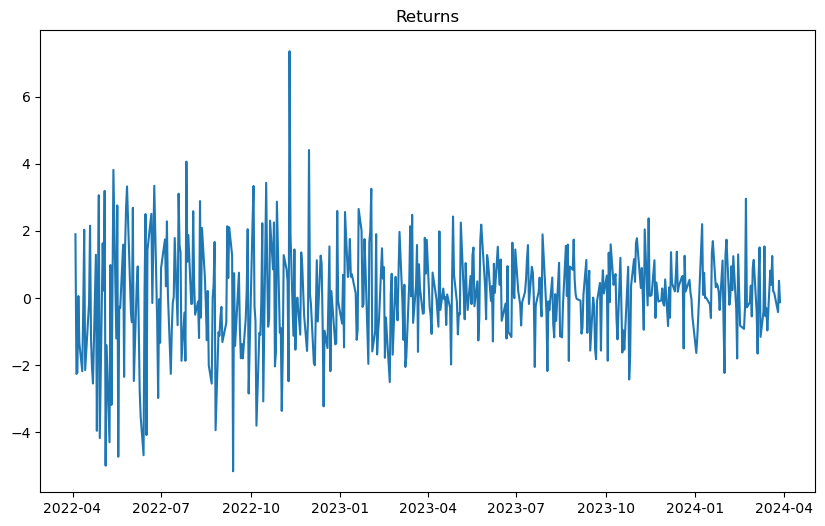

In [8]:
# Check for ARCH/GARCH effects
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.title('Returns')
plt.show()

In [9]:
# Fit an ARCH/GARCH model
model = arch_model(returns, vol='Garch', p=1, q=1)
results = model.fit(disp='off')
print(results.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -863.743
Distribution:                  Normal   AIC:                           1735.49
Method:            Maximum Likelihood   BIC:                           1752.34
                                        No. Observations:                  499
Date:                Thu, Jul 25 2024   Df Residuals:                      498
Time:                        09:20:00   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0996  5.789e-02      1.721  8.533e-02 [-1.38

In [10]:
# Forecast the three-month volatility
forecast = results.forecast(horizon=90)
volatility_forecast = forecast.variance[-1:]  # Last forecasted variance
volatility_forecast = volatility_forecast.apply(lambda x: x**0.5)  # Convert to standard deviation
print(volatility_forecast)

                h.01      h.02    h.03      h.04      h.05      h.06  \
Date                                                                   
2024-03-28  0.918856  0.918377  0.9179  0.917427  0.916956  0.916488   

                h.07     h.08    h.09      h.10  ...      h.81      h.82  \
Date                                             ...                       
2024-03-28  0.916022  0.91556  0.9151  0.914644  ...  0.888396  0.888102   

               h.83     h.84      h.85      h.86     h.87      h.88      h.89  \
Date                                                                            
2024-03-28  0.88781  0.88752  0.887231  0.886945  0.88666  0.886377  0.886095   

                h.90  
Date                  
2024-03-28  0.885816  

[1 rows x 90 columns]


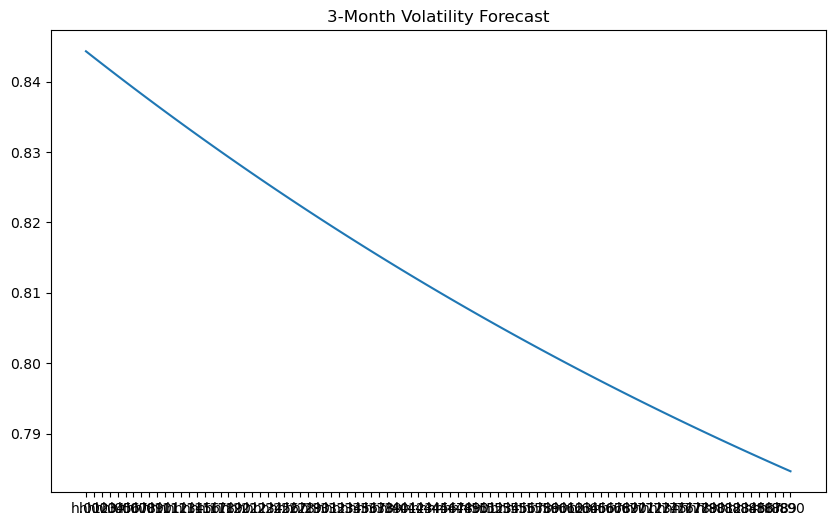

In [11]:
# Plot the forecast
plt.figure(figsize=(10,6))
plt.plot(forecast.variance[-1:].T)
plt.title('3-Month Volatility Forecast')
plt.show()

## **Part B**

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.stattools import adfuller

In [14]:
# Load the data from the Excel file
file_path = 'CMO-Historical-Data-Monthly.xlsx'
df = pd.read_excel(file_path, sheet_name='Monthly Prices', skiprows=6)

In [15]:
# Rename the first column to "Date"
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)

# Convert the Date column to datetime format
def parse_date(date_str):
    year, month = date_str[:4], date_str[5:7]
    return pd.to_datetime(f'{year}-{month}-01')

df['Date'] = df['Date'].apply(parse_date)

# Display the structure of the dataframe
print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774 entries, 0 to 773
Data columns (total 72 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           774 non-null    datetime64[ns]
 1   CRUDE_PETRO    774 non-null    float64       
 2   CRUDE_BRENT    774 non-null    float64       
 3   CRUDE_DUBAI    774 non-null    float64       
 4   CRUDE_WTI      774 non-null    object        
 5   COAL_AUS       774 non-null    object        
 6   COAL_SAFRICA   774 non-null    object        
 7   NGAS_US        774 non-null    float64       
 8   NGAS_EUR       774 non-null    float64       
 9   NGAS_JP        774 non-null    object        
 10  iNATGAS        774 non-null    object        
 11  COCOA          774 non-null    float64       
 12  COFFEE_ARABIC  774 non-null    float64       
 13  COFFEE_ROBUS   774 non-null    float64       
 14  TEA_AVG        774 non-null    float64       
 15  TEA_COLOMBO    774 non-

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774 entries, 0 to 773
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       774 non-null    datetime64[ns]
 1   sugar_eu   774 non-null    float64       
 2   sugar_us   774 non-null    float64       
 3   sugar_wld  774 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 24.3 KB
None


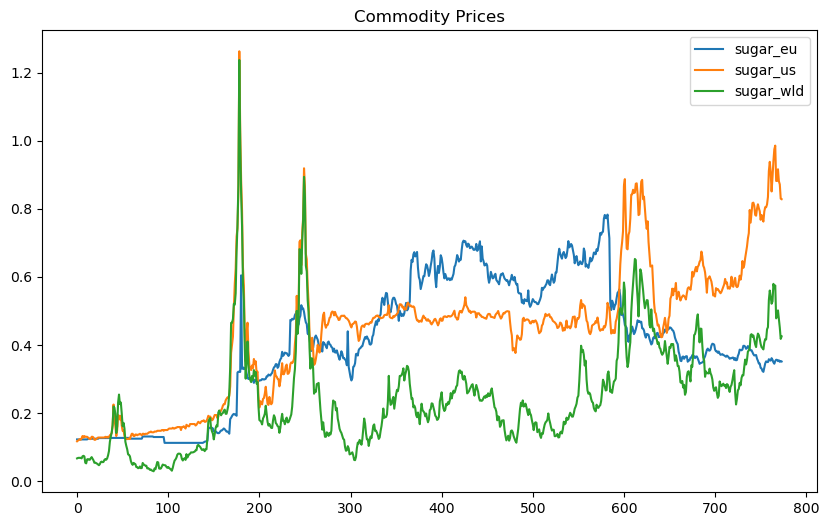

In [16]:
# Get the column numbers for each column
column_numbers = {col: idx for idx, col in enumerate(df.columns)}

# Select relevant columns
commodity = df.iloc[:, [0, 45, 46, 47]]

# Clean column names
commodity.columns = commodity.columns.str.lower().str.replace(' ', '_')

# Display the structure of the commodity dataframe
print(commodity.info())


# Exclude the Date column
commodity_data = commodity.drop(columns=['date'])


commodity_data.plot(figsize=(10, 6))
plt.title('Commodity Prices')
plt.show()




In [17]:
# Step 3: Check for stationarity using ADF test
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, val in result[4].items():
        out[f'Critical Value ({key})'] = val
    print(out)
    print('')

# Apply ADF test for each commodity
for column in commodity_data.columns:
    adf_test(commodity_data[column], title=column)

Augmented Dickey-Fuller Test: sugar_eu
ADF Test Statistic              -1.743992
p-value                          0.408601
# Lags Used                      5.000000
Number of Observations Used    768.000000
Critical Value (1%)             -3.438893
Critical Value (5%)             -2.865311
Critical Value (10%)            -2.568778
dtype: float64

Augmented Dickey-Fuller Test: sugar_us
ADF Test Statistic              -2.276776
p-value                          0.179568
# Lags Used                     11.000000
Number of Observations Used    762.000000
Critical Value (1%)             -3.438961
Critical Value (5%)             -2.865340
Critical Value (10%)            -2.568794
dtype: float64

Augmented Dickey-Fuller Test: sugar_wld
ADF Test Statistic              -3.753929
p-value                          0.003415
# Lags Used                     10.000000
Number of Observations Used    763.000000
Critical Value (1%)             -3.438950
Critical Value (5%)             -2.865335
Critical V

In [18]:
# Step 4: Differencing the series if not stationary
commodity_data_diff = commodity_data.diff().dropna()

# Convert all columns to numeric (if they are not already)
commodity_data_diff =commodity_data_diff.apply(pd.to_numeric, errors='coerce')

# Handle any potential NaN values that might be introduced
commodity_data_diff = commodity_data_diff.dropna()

# Check stationarity of differenced data
for column in commodity_data_diff.columns:
    adf_test(commodity_data_diff[column], title=f'{column} Differenced')

Augmented Dickey-Fuller Test: sugar_eu Differenced
ADF Test Statistic            -1.283114e+01
p-value                        5.870250e-24
# Lags Used                    4.000000e+00
Number of Observations Used    7.680000e+02
Critical Value (1%)           -3.438893e+00
Critical Value (5%)           -2.865311e+00
Critical Value (10%)          -2.568778e+00
dtype: float64

Augmented Dickey-Fuller Test: sugar_us Differenced
ADF Test Statistic            -9.446089e+00
p-value                        4.751457e-16
# Lags Used                    1.000000e+01
Number of Observations Used    7.620000e+02
Critical Value (1%)           -3.438961e+00
Critical Value (5%)           -2.865340e+00
Critical Value (10%)          -2.568794e+00
dtype: float64

Augmented Dickey-Fuller Test: sugar_wld Differenced
ADF Test Statistic            -9.182946e+00
p-value                        2.226496e-15
# Lags Used                    9.000000e+00
Number of Observations Used    7.630000e+02
Critical Value (1%)   

In [19]:
# Step 5: Fit VAR model if series are stationary
# Automatically select the optimal lag length based on information criteria
model = VAR(commodity_data_diff)
lag_order = model.select_order().aic  # Select lag length based on AIC
print(f'Selected Lag Length: {lag_order}')

# Fit the VAR model with the selected lag length
results = model.fit(lag_order)
print(results.summary())

Selected Lag Length: 7
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 25, Jul, 2024
Time:                     09:20:01
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -22.5040
Nobs:                     766.000    HQIC:                  -22.7500
Log likelihood:           5577.47    FPE:                1.12975e-10
AIC:                     -22.9039    Det(Omega_mle):     1.03775e-10
--------------------------------------------------------------------
Results for equation sugar_eu
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.000272         0.000675            0.403           0.687
L1.sugar_eu         -0.066242         0.036880           -1.796           0.072
L1.sugar_us         -0.102528         

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[35.26865136 13.24697368  1.24674046]
[22.02167768 12.00023322  1.24674046]
Det. terms outside the coint. relation & lagged endog. parameters for equation sugar_eu
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0016      0.001      1.568      0.117      -0.000       0.004
L1.sugar_eu     -0.1804      0.033     -5.453      0.000      -0.245      -0.116
L1.sugar_us     -0.1069      0.038     -2.788      0.005      -0.182      -0.032
L1.sugar_wld     0.0419      0.037      1.133      0.257      -0.031       0.114
L2.sugar_eu     -0.0185      0.033     -0.556      0.578      -0.084       0.047
L2.sugar_us      0.1922      0.038      4.999      0.000       0.117       0.267
L2.sugar_wld     0.0846      0.037      2.265      0.024       0.011       0.158
Det. terms outside the coint. relation & lagged endog. parameters for equation sugar_us
                   

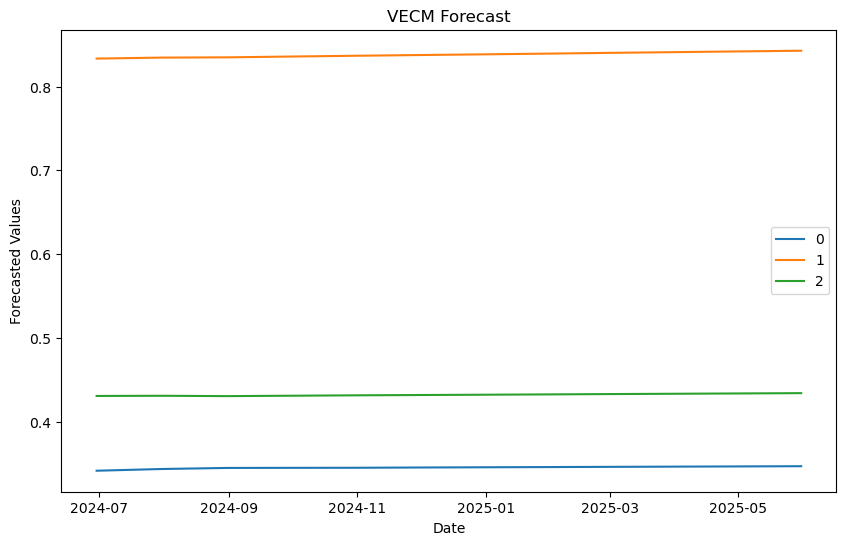

In [20]:
# Exclude the Date column
commodity_data = commodity.drop(columns=['date'])

# Perform the Johansen cointegration test
johansen_test = coint_johansen(commodity_data, det_order=1, k_ar_diff=2)
print(johansen_test.lr1)  # Trace statistic
print(johansen_test.lr2)  # Max-eigen statistic

# Fit the VECM model
vecm = VECM(commodity_data, k_ar_diff=2, coint_rank=1, deterministic='co')
vecm_fit = vecm.fit()

# Display the summary of the VECM model
print(vecm_fit.summary())

# Forecasting 12 steps ahead
forecast = vecm_fit.predict(steps=12)

# Convert forecast to DataFrame for plotting
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=commodity['date'].iloc[-1], periods=12, freq='M'))

# Plotting the forecast
plt.figure(figsize=(10, 6))
for col in forecast_df.columns:
    plt.plot(forecast_df.index, forecast_df[col], label=col)

plt.legend()
plt.title('VECM Forecast')
plt.xlabel('Date')
plt.ylabel('Forecasted Values')
plt.show()
